This notebook prepares a planet candidate catalog for the stellar population in the specified input stellar catalog.  It computes the reliability, corrected planet radius and includes useful planet properties such as robovetter score.  It outputs two catalogs, one that contains only PCs and one that contains all KOIs.

Reliability is given by

$$ R = \frac{N_{\mathrm{truePC}}}{N_{\mathrm{obsPC}}} = 1 - \frac{N_{\mathrm{obsFP}}}{N_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{F_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) $$

where $E = N_{\mathrm{obsFP}}/N_{\mathrm{trueFP}}$ is the false positive effectiveness, $F_{\mathrm{obsFP}} = N_{\mathrm{obsFP}}/N_{\mathrm{obsTCEs}}$ is the fraction of observed TCEs that are dispositioned as FP and $F_{\mathrm{obsPC}} = N_{\mathrm{obsPC}}/N_{\mathrm{obsTCEs}}$ is the fraction of TCEs dispositioned as PC.

We will separately measure $E$ and $F_{\mathrm{obsFP}}$ as binomial point processes with probabilities that depend on period and MES.  Once we have $F_{\mathrm{obsFP}}$ then $F_{\mathrm{obsPC}} = 1 - F_{\mathrm{obsFP}}$, assuming that $N_{\mathrm{obsTCEs}} = N_{\mathrm{obsPC}} + N_{\mathrm{obsFP}}$.

We think of TCEs as consisting of two sets: those that are dispositioned as FP and those that are dispositioned as PC.  We do this for both the observed TCEs, and for inverted/scrambled TCEs, where all TCEs are true false positives.  Then we can think of the vetting process as drawing from the set of TCEs, with a probability $r$ of selecting either PCs or FPs.  Then the probability distribution of selecting $c$ FPs from $n$ TCEs is given by the binomial distribution

$$P\{c\} = \left( \begin{array}{c} n \\ c \end{array} \right) r^c (1-r)^{n-c}.$$

To measure $E$ we use the inverted and scrambled data sets, where all detected TCEs are by definition FPs.  We define $E$ as the probability of drawing FPs from inverted/scrambled TCEs, found via the Bayesian inference $p(E|n, c) \propto p(c|E, n) p(E)$, where 
$$p(c|E, n) = \left( \begin{array}{c} n \\ c \end{array} \right) E^c (1-E)^{n-c}$$ and
$p(E)$ is a prior distribution of the probability $E$.  By putting the data on a grid indexed by $i,j$, we can fit effectiveness as a function parameterized by a vector $\theta$, $E(\theta,\mathrm{period},\mathrm{MES})$, as $p(\theta)|n_{i,j}, c_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) \propto p(c_{i,j}|\theta, n_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) p(\theta)$, where $p(\theta)$ is some prior distribution of the parameters.

To measure $F_{\mathrm{obsFP}}$ we perform a similar inference using the set of observed TCEs, and inferring the probability of drawing c FPs from n observed TCEs.  The inference in this case becomes $p(F_{\mathrm{obsFP}}|n, c) \propto p(c|F_{\mathrm{obsFP}}, n) p(F_{\mathrm{obsFP}})$, which we can parameterize interms of a function similar to effectiveness.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec
import pandas as pd
from astropy.io import ascii
from astropy.table import Table, vstack
import pickle
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm

import sys
sys.path.insert(0, '..')
import dr25Models as funcModels

Reliability is given by

$$ R = \frac{N_{\mathrm{truePC}}}{N_{\mathrm{obsPC}}} = 1 - \frac{N_{\mathrm{obsFP}}}{N_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{F_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{1 - F_{\mathrm{obsFP}}} \left( \frac{1 - E}{E} \right) $$

where $E = N_{\mathrm{obsFP}}/N_{\mathrm{trueFP}}$, $F_{\mathrm{obsFP}} = N_{\mathrm{obsFP}}/N_{\mathrm{obsTCEs}}$ is the fraction of observed TCEs that are dispositioned as FP and $F_{\mathrm{obsPC}} = N_{\mathrm{obsPC}}/N_{\mathrm{obsTCEs}}$ is the fraction of TCEs dispositioned as PC.

We get $E$ and $F_{\mathrm{obsFP}}$ from the outputs of the notebooks binomialFPEffectiveness.ipynb and binomialObsFPRate.ipynb.

In [2]:
# dataType = "highreliability"
# bootstrapType = ""
# scoreCut = 0;
# # outputDir = bootstrapType + "Output/"
# outputDir = dataType + "Sc" + str(scoreCut) + "Output/"
# print(outputDir)

# htmlLabel = dataType + "Sc" + str(scoreCut) + bootstrapType
# print(htmlLabel)

dataType = "fpwgpc"
bootstrapType = ""
outputDir = dataType + bootstrapType + "Output/"

htmlLabel = dataType + bootstrapType

# set the effectiveness model
# fpEffModel = "constant" # for score cut 0.9
fpEffModel = "rotatedLogisticX0"
# set the obs FP rate model
obsModel = "rotatedLogisticX0"

stellarType = "GK"

tt = pd.read_pickle(outputDir + "fpEffectivenessJointTable.pkl")
# tt = pd.read_pickle("fpwgpcOutput/fpEffectivenessJointTable.pkl")
tm = tt[tt.Model == fpEffModel]
fpEffXRange = tm.periodRange.values[0]
fpEffYRange = tm.mesRange.values[0]
obsXRange = tm.periodRange.values[0]
obsYRange = tm.mesRange.values[0]
fpEffTheta = tm.medianMCMCFpeTheta.values[0] 
obsTheta = tm.medianMCMCOpsFPTheta.values[0] 


In [3]:
cellPeriod, cellMes = np.meshgrid(np.array(np.linspace(fpEffXRange[0], fpEffXRange[1], 200)), 
                          np.array(np.linspace(fpEffYRange[0], fpEffYRange[1], 200)))

effFit = funcModels.evaluateModel(cellPeriod, cellMes, fpEffTheta, fpEffXRange, fpEffYRange, fpEffModel)
obsFit = funcModels.evaluateModel(cellPeriod, cellMes, obsTheta, obsXRange, obsYRange, obsModel)

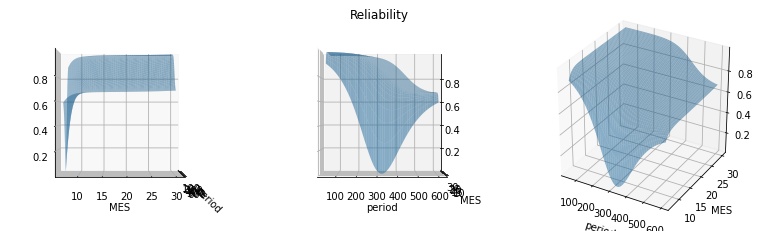

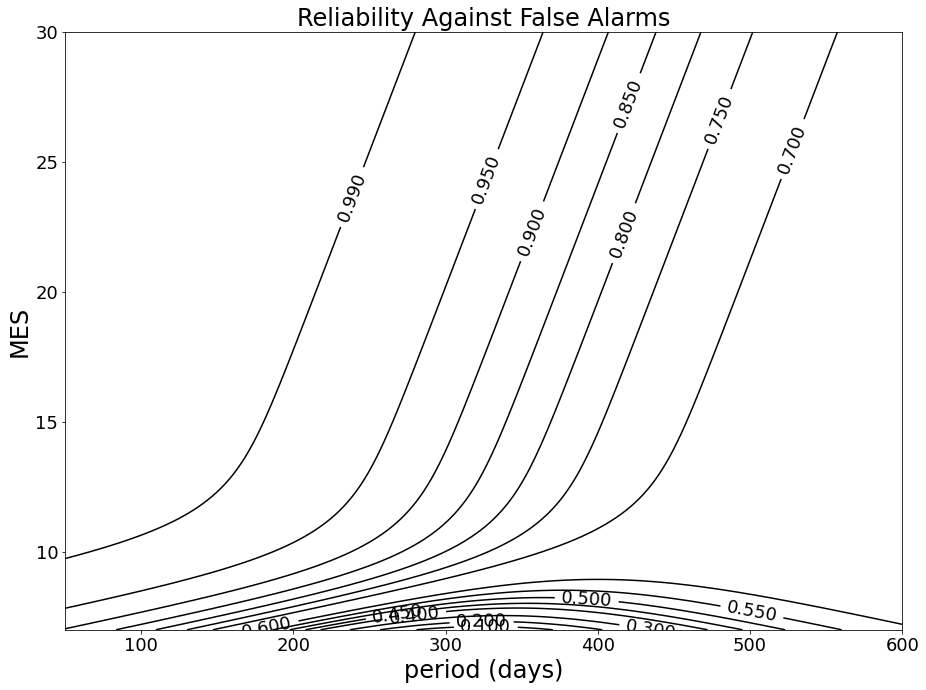

In [4]:
fig = plt.figure(figsize=plt.figaspect(0.3));
R = 1 - (obsFit/(1-obsFit))*((1-effFit)/effFit)

pR = R;
pR[pR<0] = 0;

ax = fig.add_subplot(1, 3, 1, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,0)

ax = fig.add_subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,-90)
plt.title("Reliability");

ax = fig.add_subplot(1, 3, 3, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");


fig, ax = plt.subplots(figsize=(15,11));
CS = ax.contour(cellPeriod, cellMes, pR, colors='k', levels = [0, 0.1, 0.2, 0.3, 0.4, .45, .5, .55, .6, .7, .75, .8, .85, .9, .95, .99]);
ax.clabel(CS, inline=1, fontsize=18);
ax.tick_params(axis = "both", labelsize = 18)
plt.xlabel("period (days)", fontsize = 24);
plt.ylabel("MES", fontsize = 24);
plt.savefig(outputDir + "reliabilityContours.pdf",bbox_inches='tight')
plt.title("Reliability Against False Alarms", fontsize = 24);





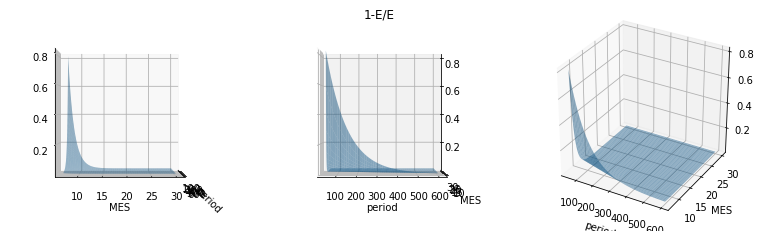

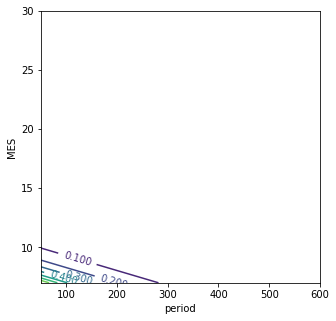

In [5]:
fig = plt.figure(figsize=plt.figaspect(0.3));
R = (1-effFit)/effFit

pR = R;
pR[pR<0] = 0;

ax = fig.add_subplot(1, 3, 1, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,0)

ax = fig.add_subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,-90)
plt.title("1-E/E");

ax = fig.add_subplot(1, 3, 3, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");


fig, ax = plt.subplots(figsize=(5,5));
CS = ax.contour(cellPeriod, cellMes, pR);
ax.clabel(CS, inline=1, fontsize=10);
plt.xlabel("period");
plt.ylabel("MES");



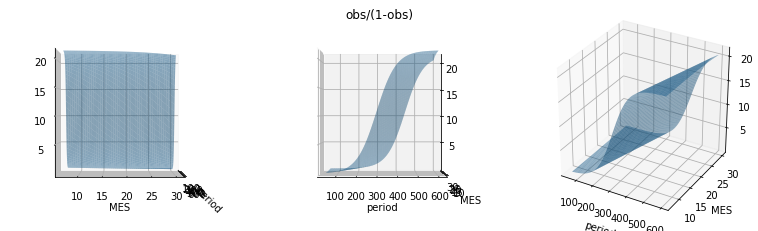

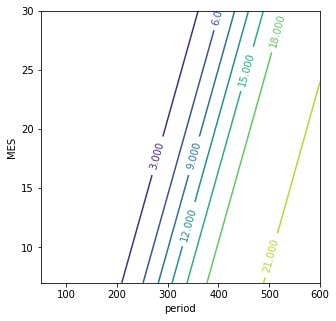

In [6]:
fig = plt.figure(figsize=plt.figaspect(0.3));
R = obsFit/(1-obsFit)

pR = R;
pR[pR<0] = 0;

ax = fig.add_subplot(1, 3, 1, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,0)

ax = fig.add_subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,-90)
plt.title("obs/(1-obs)");

ax = fig.add_subplot(1, 3, 3, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, pR, alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");


fig, ax = plt.subplots(figsize=(5,5));
CS = ax.contour(cellPeriod, cellMes, pR);
ax.clabel(CS, inline=1, fontsize=10);
plt.xlabel("period");
plt.ylabel("MES");





/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


array([[       nan, 0.99873361, 0.89814541],
       [       nan, 0.9931808 , 0.82775849],
       [       nan, 0.89891003, 0.57121041]])

<Figure size 216x216 with 0 Axes>

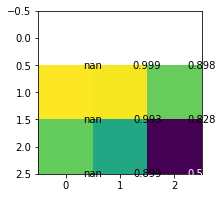

In [7]:
R = 1 - (obsFit/(1-obsFit))*((1-effFit)/effFit)

pR = R;
pR[pR<0] = 0;

sp = np.zeros([3,3])
sPeriod = np.array([[0, 10, 200], [0, 10, 200], [0, 10, 200]])
sMes = np.array([[0, 0, 0], [10, 10, 10], [30, 30, 30]])
sp[0,0] = np.mean(np.mean(pR[np.where((cellPeriod > 0) & (cellPeriod <= 20) & (cellMes > 20) & (cellMes <= 200))]))
sp[0,1] = np.mean(np.mean(pR[np.where((cellPeriod > 20) & (cellPeriod <= 200) & (cellMes > 20) & (cellMes <= 200))]))
sp[0,2] = np.mean(np.mean(pR[np.where((cellPeriod > 200) & (cellPeriod <= 500) & (cellMes > 20) & (cellMes <= 200))]))

sp[1,0] = np.mean(np.mean(pR[np.where((cellPeriod > 0) & (cellPeriod <= 20) & (cellMes > 10) & (cellMes <= 20))]))
sp[1,1] = np.mean(np.mean(pR[np.where((cellPeriod > 20) & (cellPeriod <= 200) & (cellMes > 10) & (cellMes <= 20))]))
sp[1,2] = np.mean(np.mean(pR[np.where((cellPeriod > 200) & (cellPeriod <= 500) & (cellMes > 10) & (cellMes <= 20))]))

sp[2,0] = np.mean(np.mean(pR[np.where((cellPeriod > 0) & (cellPeriod <= 20) & (cellMes > 0) & (cellMes <= 10))]))
sp[2,1] = np.mean(np.mean(pR[np.where((cellPeriod > 20) & (cellPeriod <= 200) & (cellMes > 0) & (cellMes <= 10))]))
sp[2,2] = np.mean(np.mean(pR[np.where((cellPeriod > 200) & (cellPeriod <= 500) & (cellMes > 0) & (cellMes <= 10))]))

x = np.array([[0, 1, 2], [0, 1, 2], [0, 1, 2]])
y = np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2]])
dx = 1
dy = 1
imageSize = (3,3)
plt.figure(figsize=imageSize);
fig, ax = plt.subplots(figsize=imageSize);
da = np.transpose(sp);
ax.imshow(da);
# ax.imshow(da, origin='lower');
arrayShape = da.shape;
for i in range(arrayShape[0]):
    for j in range(arrayShape[1]):
        if da[i, j] < 0.7:
            c = "w"
        else:
            c = "k"
        text = ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, round(da[i, j],3),
                       ha="center", va="center", color=c);

sp



In [8]:
def computeReliabiltyPosterior(xp, yp, eSamples, oSamples):
    r = np.zeros(np.shape(eSamples)[0])
    for i in range(np.shape(eSamples)[0]):
        e = funcModels.evaluateModel(xp, yp, eSamples[i,:], fpEffXRange, fpEffYRange, fpEffModel)
        o = funcModels.evaluateModel(xp, yp, oSamples[i,:], obsXRange, obsYRange, obsModel)
        r[i] = 1 - (o/(1-o))*((1-e)/e)

    e = funcModels.evaluateModel(xp, yp, fpEffTheta, fpEffXRange, fpEffYRange, fpEffModel)
    o = funcModels.evaluateModel(xp, yp, obsTheta, obsXRange, obsYRange, obsModel)
    f = 1 - (o/(1-o))*((1-e)/e)

    return r, f

In [9]:
samples = np.load(outputDir + "jointPosteriors_" + str(fpEffModel) + "_" + str(obsModel) + ".npy");
# samples = np.load("fpwgpcOutput/jointPosteriors_" + str(fpEffModel) + "_" + str(obsModel) + ".npy");
nFpeParams = len(funcModels.initRateModel(fpEffModel));
eSamples = samples[:,0:nFpeParams];
oSamples = samples[:,nFpeParams:];

r1, f1 = computeReliabiltyPosterior(200., 25., eSamples, oSamples)
r2, f2 = computeReliabiltyPosterior(365., 10., eSamples, oSamples)
r3, f3 = computeReliabiltyPosterior(365., 8., eSamples, oSamples)




f1:0.9961849215973666
f2:0.6982312418405561
f3:0.44771180601049787


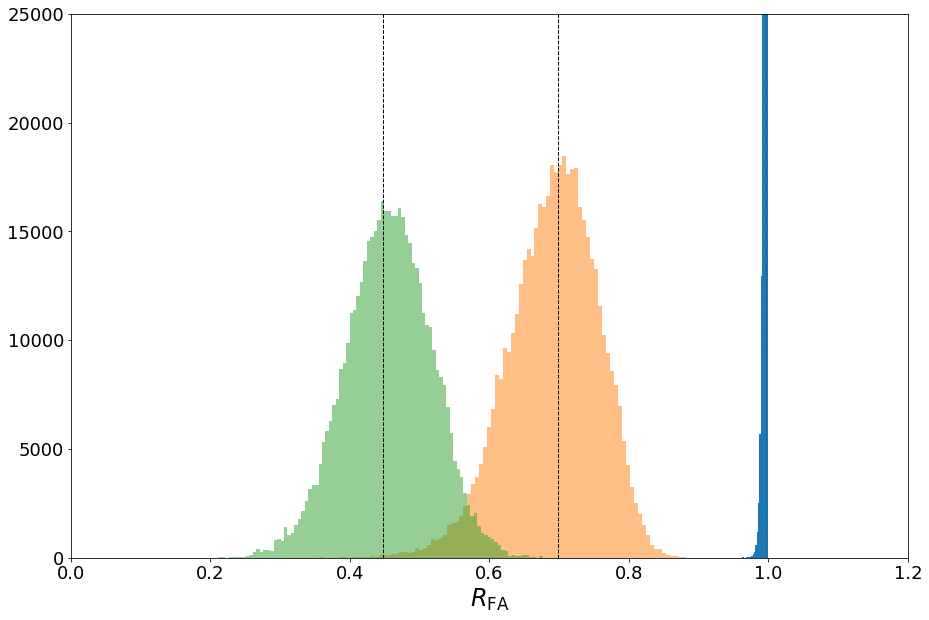

In [10]:
ymax = 25000
plt.figure(figsize=(15,10))
plt.hist(r1, 20);
plt.plot([f1, f1], [0, ymax], color='k', linestyle='--', linewidth=1, alpha = 0.2)

plt.hist(r2, 100, alpha = 0.5);
plt.plot([f2, f2], [0, ymax], color='k', linestyle='--', linewidth=1, alpha = 1)

plt.hist(r3, 100, alpha = 0.5);
plt.plot([f3, f3], [0, ymax], color='k', linestyle='--', linewidth=1, alpha = 1)
plt.ylim(0, ymax)
plt.xlim(0, 1.2)
plt.tick_params(labelsize = 18)
plt.xlabel("$R_\mathrm{FA}$", fontSize = 24);

plt.savefig(outputDir + "reliabilityExamples.pdf",bbox_inches='tight')

print("f1:" + str(f1))
print("f2:" + str(f2))
print("f3:" + str(f3))


In [11]:
import requests
if False:
    selectStr = "kepid,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,koi_ror,koi_ror_err1,koi_ror_err2"
    urlDr25Koi = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr25_koi&select=" + selectStr

    r = requests.get(urlDr25Koi)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    dr25Koi = pd.read_csv(fh, dtype={"kepoi_name":str})
    dr25Koi.to_csv("koiCatalogs/dr25_kois_archive.txt", index=False)
else:
    dr25Koi = pd.read_csv("koiCatalogs/dr25_kois_archive.txt", dtype={"kepoi_name":str})

print("Loaded " + str(len(dr25Koi)) + " KOIs")





Loaded 8054 KOIs


In [12]:
# add TCE_ID for a later merge

TCE_ID = []
for i in range(len(dr25Koi)):
    TCE_ID.append("%09d"%dr25Koi.kepid.loc[i] + "-%02d"%dr25Koi.koi_tce_plnt_num.loc[i])

dr25Koi["TCE_ID"] = TCE_ID


In [13]:
# restrict the population to stars in the Travis' catalog
if bootstrapType == "":
    starlist = "../stellarCatalogs/dr25_stellar_berger2019_clean_" + stellarType + ".txt"
else:
    starlist = "bootstrapOut/" + bootstrapType + "StellarCatalog.csv"

dr25CleanStellarIso = pd.read_csv(starlist)
# dr25Koi = dr25Koi[dr25Koi.kepid.isin(dr25CleanStellarIso.kepid)]
# merge in only iso_rad and uncertainties from the stellar table
dr25Koi = pd.merge(dr25Koi, dr25CleanStellarIso[["kepid","radius","radius_err1","radius_err2","teff"]], on="kepid", how="inner")
dr25Koi = dr25Koi.reset_index(drop=True)

print("length of dr25CleanStellarIso = " + str(len(dr25CleanStellarIso.kepid)))
print("length of unique dr25CleanStellarIso = " + str(len(np.unique(dr25CleanStellarIso.kepid))))
print("length of dr25Koi = " + str(len(dr25Koi.kepoi_name)))
print("length of unique dr25Koi = " + str(len(np.unique(dr25Koi.kepoi_name))))


length of dr25CleanStellarIso = 57015
length of unique dr25CleanStellarIso = 57015
length of dr25Koi = 2509
length of unique dr25Koi = 2509


In [14]:
print("length of unique dr25Koi = " + str(len(np.unique(dr25Koi.kepoi_name))))
print("length of unique dr25Koi kepids = " + str(len(np.unique(dr25Koi.kepid))))

np.unique(dr25Koi.kepoi_name)

length of unique dr25Koi = 2509
length of unique dr25Koi kepids = 1986


array(['K00003.01', 'K00008.01', 'K00011.01', ..., 'K08293.01',
       'K08295.01', 'K08296.01'], dtype=object)

In [15]:
a = [1,5,3,7,3,7,2,6,5,3,4]
np.sort(a)

array([1, 2, 3, 3, 3, 4, 5, 5, 6, 7, 7])

In [16]:
# correct the planet radii with the new catalog

rEarth = 6356.8 # km
rSun = 695700 # km

dr25Koi['corrected_prad'] = dr25Koi['koi_ror']*dr25Koi['radius']*rSun/rEarth;
dr25Koi['corrected_prad_err1'] = np.sqrt(dr25Koi['koi_ror_err1']**2*dr25Koi['radius']**2
                                        +dr25Koi['koi_ror']**2*dr25Koi['radius_err1']**2)*rSun/rEarth;
dr25Koi['corrected_prad_err2'] = -np.sqrt(dr25Koi['koi_ror_err2']**2*dr25Koi['radius']**2
                                        +dr25Koi['koi_ror']**2*dr25Koi['radius_err2']**2)*rSun/rEarth;

dr25Koi = dr25Koi[~np.isnan(dr25Koi.koi_prad)]

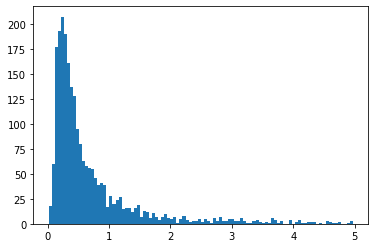

In [17]:
v = dr25Koi.corrected_prad_err1/dr25Koi.koi_prad_err1
plt.hist(v[v<5], 100);

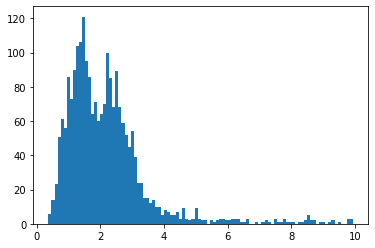

In [18]:
plt.hist(dr25Koi['corrected_prad'][dr25Koi['corrected_prad']<10], 100);

(50.0, 400.0)

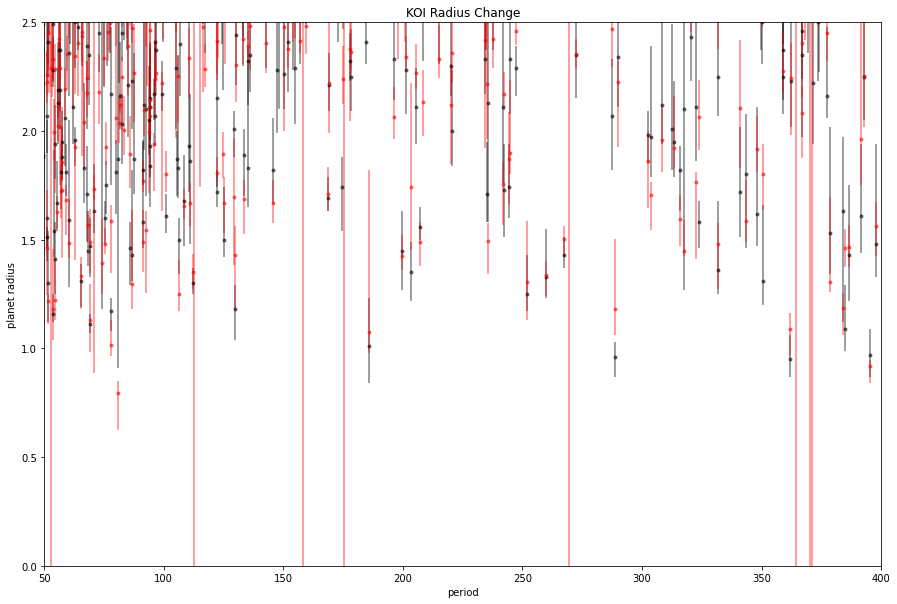

In [19]:
fig, ax = plt.subplots(figsize=(15,10));
ax.errorbar(dr25Koi.koi_period, dr25Koi.koi_prad, 
            yerr = [-dr25Koi.koi_prad_err2, dr25Koi.koi_prad_err1],
            fmt="k.", alpha = 0.5);
ax.errorbar(dr25Koi.koi_period, dr25Koi.corrected_prad, 
            yerr = [-dr25Koi.corrected_prad_err2, dr25Koi.corrected_prad_err1],
            fmt="r.", alpha = 0.5);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Radius Change");
plt.ylim([0, 2.5])
plt.xlim([50, 400])



In [20]:
dr25Fpp = ascii.read("../data/q1_q17_dr25_koifpp.txt")
dr25FppPd = dr25Fpp.to_pandas()

In [21]:
mergedDr25Koi = pd.merge(dr25Koi, dr25FppPd, on="kepoi_name", how="inner")



In [22]:
if dataType == "fpwgpcKep2":
    mesFactor = 1.4;
else:
    mesFactor = 1;
mergedDr25Koi.loc[:,"fpEffectiveness"] = pd.Series(
                            funcModels.evaluateModel(mergedDr25Koi.koi_period,
                             mesFactor*mergedDr25Koi.koi_max_mult_ev, fpEffTheta, 
                             fpEffXRange, fpEffYRange, fpEffModel), index = mergedDr25Koi.index)
mergedDr25Koi.loc[:,"obsFpRate"] = pd.Series(
                            funcModels.evaluateModel(mergedDr25Koi.koi_period,
                             mesFactor*mergedDr25Koi.koi_max_mult_ev, obsTheta, 
                             obsXRange, obsYRange, obsModel), index = mergedDr25Koi.index)

mergedDr25Koi.loc[:,"reliability"] = pd.Series(
    1-(mergedDr25Koi.obsFpRate/(1-mergedDr25Koi.obsFpRate))
    *(1-mergedDr25Koi.fpEffectiveness)/mergedDr25Koi.fpEffectiveness, index = mergedDr25Koi.index)
    
mergedDr25Koi.reliability[mergedDr25Koi.reliability < 0.] = 0.

../dr25Models.py:94: RuntimeWarning: overflow encountered in exp
  r = amp/(1 + np.exp(k*(xr + 0.5 - x0)));
/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


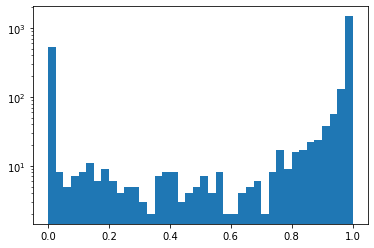

In [23]:
plt.hist(mergedDr25Koi.koi_score, 40);
plt.yscale('log', nonposy='clip')



In [24]:
np.sum(np.isnan(mergedDr25Koi.fpp_prob) & mergedDr25Koi.koi_period > 50)

0

In [25]:
mergedDr25Koi[np.abs(mergedDr25Koi.koi_period - mergedDr25Koi.fpp_koi_period)>1e-2]

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,corrected_prad,corrected_prad_err1,corrected_prad_err2,rowid,kepid_y,fpp_koi_period,fpp_prob,fpEffectiveness,obsFpRate,reliability
1933,9394762,K05664.01,1,FALSE POSITIVE,0.0,77.138911,11.215458,3.39,1.02,-0.27,...,3.427388,22.922429,-1.060969,6112,9394762,308.57,0.68,0.961568,0.111874,0.994965


In [26]:
mergedDr25Koi["fpp_prob_use"] = mergedDr25Koi["fpp_prob"]
mergedDr25Koi.fpp_prob_use[np.isnan(mergedDr25Koi.fpp_prob)] = 1
mergedDr25Koi.fpp_prob_use[np.abs(mergedDr25Koi.koi_period - mergedDr25Koi.fpp_koi_period)>1e-2] = 1



/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
mergedDr25Koi[np.abs(mergedDr25Koi.koi_period - mergedDr25Koi.fpp_koi_period)>1e-2]

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,corrected_prad_err1,corrected_prad_err2,rowid,kepid_y,fpp_koi_period,fpp_prob,fpEffectiveness,obsFpRate,reliability,fpp_prob_use
1933,9394762,K05664.01,1,FALSE POSITIVE,0.0,77.138911,11.215458,3.39,1.02,-0.27,...,22.922429,-1.060969,6112,9394762,308.57,0.68,0.961568,0.111874,0.994965,1.0


In [28]:
mergedDr25Koi["totalReliability"] = (1-mergedDr25Koi.fpp_prob_use)*mergedDr25Koi.reliability

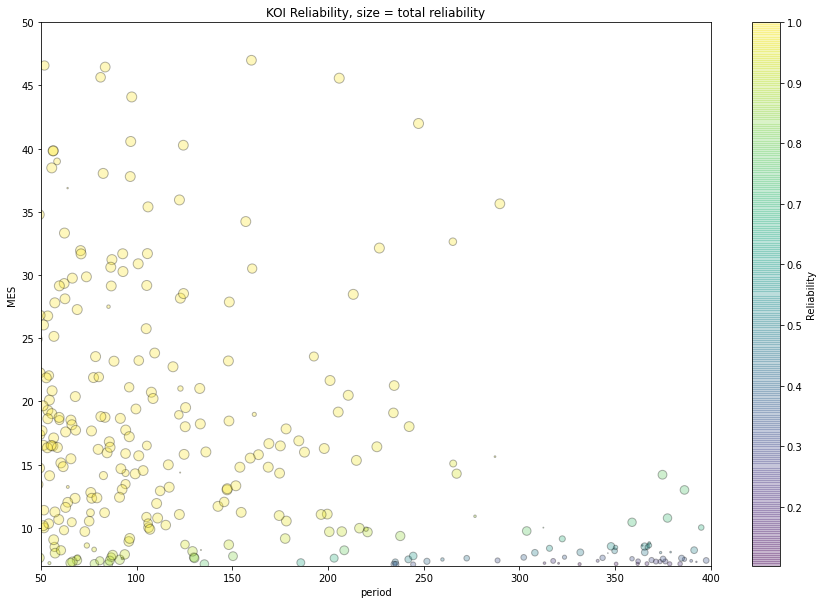

In [29]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.koi_max_mult_ev, cmap="viridis", 
                 c=mergedDr25Koi.reliability, edgecolors='k', s=100*mergedDr25Koi.totalReliability, alpha = 0.3);
plt.xlabel("period");
plt.ylabel("MES");
plt.title("KOI Reliability, size = total reliability");
plt.ylim([7, 50])
plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");



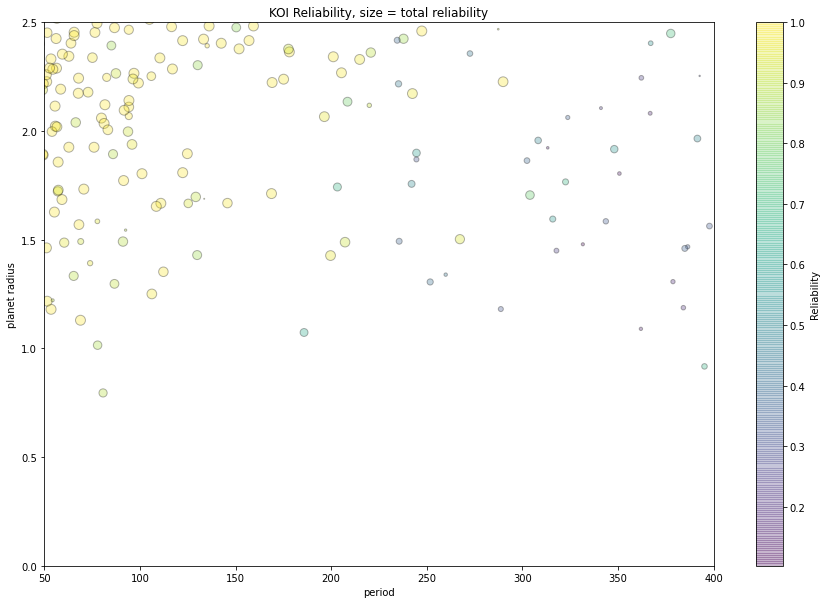

In [30]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=mergedDr25Koi.reliability, edgecolors='k', s=100*mergedDr25Koi.totalReliability, alpha = 0.3);
plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Reliability, size = total reliability");
plt.ylim([0, 2.5])
plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");




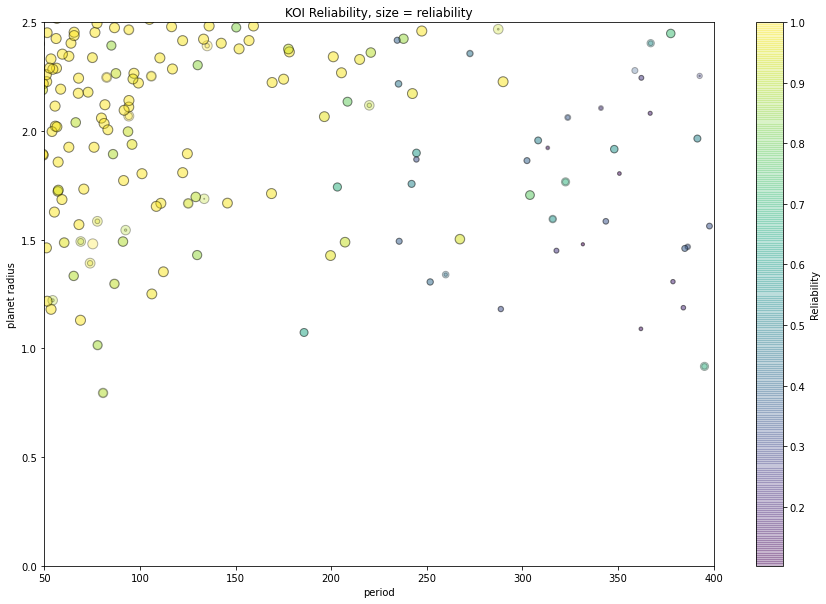

In [31]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=mergedDr25Koi.reliability, edgecolors='k', s=100*mergedDr25Koi.reliability, alpha = 0.3);
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=mergedDr25Koi.reliability, edgecolors='k', s=100*mergedDr25Koi.totalReliability, alpha = 0.3);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Reliability, size = reliability");
plt.ylim([0, 2.5])
plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");





In [32]:
dataLoc = "../data/"
if dataType == "dr25":
    obsTceList = dataLoc + "kplr_dr25_obs_tces.txt"
else:
#    obsTceList = dataLoc + "kplr_dr25_obs_fpwgpc_tces.txt"
    obsTceList = dataLoc + "kplr_dr25_obs_" + dataType + "_tces.txt"

obsTcesFull = ascii.read(obsTceList);
obsTcesFullPd = obsTcesFull.to_pandas();

mergedDr25Koi = pd.merge(mergedDr25Koi, obsTcesFullPd[["TCE_ID","Disp"]], on="TCE_ID", how="inner")


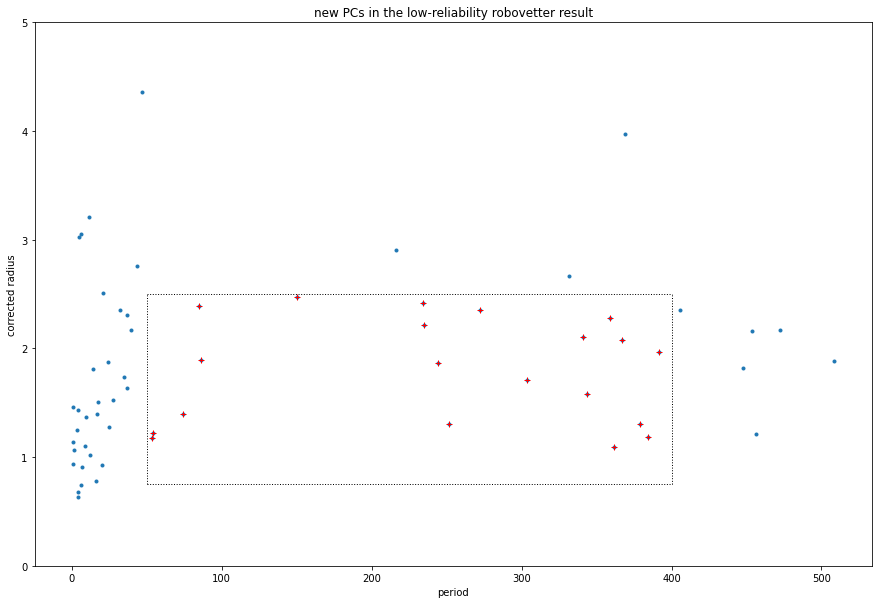

In [33]:
newPCs = mergedDr25Koi[(mergedDr25Koi.koi_pdisposition == "FALSE POSITIVE") & (mergedDr25Koi.Disp == "PC")]
newPCsInBox = newPCs[(newPCs.koi_period >= 50) & (newPCs.koi_period <= 400) 
                     & (newPCs.corrected_prad >= 0.75) & (newPCs.corrected_prad <= 2.5)]
lostPCs = mergedDr25Koi[(mergedDr25Koi.koi_pdisposition == "CANDIDATE") & (mergedDr25Koi.Disp == "FP")]
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.plot(newPCs.koi_period, newPCs.corrected_prad, '.');
scf = ax.plot(newPCsInBox.koi_period, newPCsInBox.corrected_prad, 'r+');
# plt.xlim([50, 400])
plt.plot([400, 400], [0.75, 2.5], color='k', linestyle=':', linewidth=1)
plt.plot([50, 400], [0.75, 0.75], color='k', linestyle=':', linewidth=1)
plt.plot([50, 400], [2.5, 2.5], color='k', linestyle=':', linewidth=1)
plt.plot([50, 50], [0.75, 2.5], color='k', linestyle=':', linewidth=1)
plt.ylim([0, 5])
plt.xlabel("period");
plt.ylabel("corrected radius");
plt.title("new PCs in the low-reliability robovetter result");


In [34]:
newPCsInBox

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,rowid,kepid_y,fpp_koi_period,fpp_prob,fpEffectiveness,obsFpRate,reliability,fpp_prob_use,totalReliability,Disp
436,5706595,K02183.03,3,FALSE POSITIVE,0.404,150.381954,7.760867,2.26,0.31,-0.16,...,3024,5706595,150.382,0.0710,0.844369,0.470013,0.836541,0.0710,0.777146,PC
845,10387742,K02583.02,2,FALSE POSITIVE,0.217,251.751200,7.355168,1.25,0.18,-0.08,...,2787,10387742,251.751,0.0570,0.907764,0.853496,0.408053,0.0570,0.384794,PC
1072,11774991,K02173.02,2,FALSE POSITIVE,0.000,53.578305,18.636635,1.16,0.09,-0.04,...,2975,11774991,53.578,0.0010,0.984683,0.027581,0.999559,0.0010,0.998559,PC
2104,5638699,K08256.01,1,FALSE POSITIVE,0.110,343.564460,7.629894,1.80,0.28,-0.34,...,7981,5638699,343.564,0.1100,0.957742,0.938043,0.331968,0.1100,0.295451,PC
2119,3218844,K07646.01,1,FALSE POSITIVE,0.147,85.112898,7.132443,2.21,0.72,-0.24,...,7215,3218844,85.113,0.1000,0.653829,0.204465,0.863923,0.1000,0.777530,PC
2129,5871116,K08258.01,1,FALSE POSITIVE,0.272,54.432903,7.211745,1.41,0.17,-0.16,...,7983,5871116,54.433,0.9000,0.599935,0.119192,0.909761,0.9000,0.090976,PC
2130,6032318,K08260.01,1,FALSE POSITIVE,0.107,235.206130,7.296207,1.71,0.24,-0.13,...,7985,6032318,235.206,0.1100,0.891851,0.818736,0.452277,0.1100,0.402527,PC
2131,6182508,K08261.01,1,FALSE POSITIVE,0.128,85.977043,7.407291,1.46,0.12,-0.17,...,7986,6182508,85.977,0.0760,0.699985,0.201372,0.891929,0.0760,0.824143,PC
2193,12644020,K08083.01,1,FALSE POSITIVE,0.152,234.524445,7.122703,2.33,0.28,-0.16,...,7969,12644020,234.524,0.0360,0.879456,0.819832,0.376296,0.0360,0.362749,PC
2196,9209808,K08281.01,1,FALSE POSITIVE,0.141,244.547128,7.105086,1.74,0.20,-0.14,...,8050,9209808,244.547,0.1900,0.887076,0.842498,0.319063,0.1900,0.258441,PC


In [35]:
newPCs.to_csv(outputDir + "newPCsHighCompleteness.txt", 
              columns=["TCE_ID", "kepoi_name", "koi_period", "corrected_prad", "totalReliability", "reliability", "fpp_prob_use"],
             index=False)
newPCsInBox.to_csv(outputDir + "newPCsHighCompletenessInBox.txt", 
                   columns=["TCE_ID", "kepoi_name", "koi_period", "corrected_prad", "totalReliability", "reliability", "fpp_prob_use"],
                  index=False)


In [ ]:

# dr25PC = mergedDr25Koi[mergedDr25Koi.koi_pdisposition == "CANDIDATE"]
# dr25FP = mergedDr25Koi[mergedDr25Koi.koi_pdisposition == "FALSE POSITIVE"]
dr25PC = mergedDr25Koi[(mergedDr25Koi.Disp == "PC") & (mergedDr25Koi.koi_score >= scoreCut)]
dr25FP = mergedDr25Koi[(mergedDr25Koi.Disp == "FP") | (mergedDr25Koi.koi_score < scoreCut)]

print("There are " + str(len(dr25PC)) + " PCs in " + str(len(dr25CleanStellarIso)) + " observed targets")
print("There are " + str(len(dr25FP)) + " FPs in " + str(len(dr25CleanStellarIso)) + " observed targets")

# remove those with corrected_prad = NAN
dr25PC = dr25PC[~np.isnan(dr25PC.corrected_prad)]
dr25FP = dr25FP[~np.isnan(dr25FP.corrected_prad)]
mergedDr25Koi = mergedDr25Koi[~np.isnan(mergedDr25Koi.corrected_prad)]

print("after removing NaNs")
print("There are " + str(len(dr25PC)) + " PCs in " + str(len(dr25CleanStellarIso)) + " observed targets")
print("There are " + str(len(dr25FP)) + " FPs in " + str(len(dr25CleanStellarIso)) + " observed targets")


In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.koi_max_mult_ev, cmap="viridis", 
                 c=dr25PC.reliability, edgecolors='k', s=100*dr25PC.totalReliability, alpha = 0.3);
plt.xlabel("period");
plt.ylabel("MES");
plt.title("PC Reliability, size = total reliability");
#plt.ylim([7, 30])
#plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");




In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, cmap="viridis", 
                 c=dr25PC.reliability, edgecolors='k', s=100*dr25PC.totalReliability, alpha = 0.3);
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, s=100*dr25PC.totalReliability, 
                 c=dr25PC.reliability, facecolors='none', edgecolors='k', alpha = 0.3);
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')
plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("PC Reliability, size = reliability");
#plt.ylim([0, 2.5])
#plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");



In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, cmap="viridis", 
                 c=dr25PC.reliability, edgecolors='k', s=100*dr25PC.totalReliability, alpha = 0.3);
plt.xlabel("period", fontsize = 24);
plt.ylabel("corrected planet radius", fontsize = 24);
plt.title("PC FA Reliability, size = total reliability", fontsize = 24);
plt.ylim([0, 2.5])
plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("FA Reliability");
plt.savefig(outputDir + "pcReliability.pdf",bbox_inches='tight')

plt.plot([200, 200], [1, 2], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [1, 1], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [2, 2], color='k', linestyle='--', linewidth=1)

fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.koi_prad, cmap="viridis", 
                 c=dr25PC.reliability, edgecolors='k', s=100*dr25PC.totalReliability, alpha = 0.3);
plt.xlabel("period", fontsize = 24);
plt.ylabel("DR25 planet radius", fontsize = 24);
plt.title("PC FA Reliability, size = total reliability", fontsize = 24);
plt.ylim([0, 2.5])
plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");
plt.savefig(outputDir + "pcReliability.pdf",bbox_inches='tight')

plt.plot([200, 200], [1, 2], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [1, 1], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [2, 2], color='k', linestyle='--', linewidth=1)




In [ ]:
plt.figure();
plt.hist(dr25PC[(dr25PC.koi_period>250) & (dr25PC.koi_period<400) & (dr25PC.corrected_prad<2.5)].totalReliability, 20);
plt.xlabel("total reliability")
plt.xlim(0,1)
plt.figure();
plt.hist(dr25PC[(dr25PC.koi_period>250) & (dr25PC.koi_period<400) & (dr25PC.corrected_prad<2.5)].reliability, 20);
plt.xlabel("FA reliability")
plt.xlim(0,1)

print("sum of totalreliability for 50 < p < 400 and r < 2.5 for " 
      + str(len(dr25PC[(dr25PC.koi_period>50) & (dr25PC.koi_period<400) 
                          & (dr25PC.corrected_prad<2.5)])) + " planets: "
      + str(np.sum(dr25PC[(dr25PC.koi_period>50) & (dr25PC.koi_period<400) 
                          & (dr25PC.corrected_prad<2.5)].totalReliability)))
print("sum of totalreliability for 50 < p < 200 and 1 < r < 2 for " 
      + str(len(dr25PC[(dr25PC.koi_period>50) & (dr25PC.koi_period<400) 
                          & (dr25PC.corrected_prad>1) & (dr25PC.corrected_prad<2)])) + " planets: "
      + str(np.sum(dr25PC[(dr25PC.koi_period>50) & (dr25PC.koi_period<400) 
                          & (dr25PC.corrected_prad>1) & (dr25PC.corrected_prad<2)].totalReliability)))
print("sum of totalreliability for 250 < p < 400 and r < 2.5 for " 
      + str(len(dr25PC[(dr25PC.koi_period>250) & (dr25PC.koi_period<400) 
                          & (dr25PC.corrected_prad<2.5)])) + " planets: "
      + str(np.sum(dr25PC[(dr25PC.koi_period>250) & (dr25PC.koi_period<400) 
                          & (dr25PC.corrected_prad<2.5)].totalReliability)))
print("sum of totalreliability for 250 < p < 400 and r < 1.5 for " 
      + str(len(dr25PC[(dr25PC.koi_period>250) & (dr25PC.koi_period<400) 
                          & (dr25PC.corrected_prad<1.5)])) + " planets: "
      + str(np.sum(dr25PC[(dr25PC.koi_period>250) & (dr25PC.koi_period<400) 
                          & (dr25PC.corrected_prad<1.5)].totalReliability)))


In [ ]:
dr25PcInRange = dr25PC[(dr25PC.koi_period>50)&(dr25PC.koi_period<400)&(dr25PC.corrected_prad>0)&(dr25PC.corrected_prad<2.5)]


In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
rs = mergedDr25Koi.totalReliability*mergedDr25Koi.koi_score
ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, marker="+", alpha=0.2);
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=rs, edgecolors='k', s=100*rs, alpha = 0.3);
plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Total Reliability x Score");
plt.ylim([0, 2.5])
plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("KOI Total Reliability x Score");




In [ ]:
plt.hist(dr25PC.corrected_prad/dr25PC.koi_prad, 100);
#plt.yscale('log', nonposy='clip')



In [ ]:
plt.hist(dr25CleanStellarIso.radius[dr25CleanStellarIso.radius<2]/dr25CleanStellarIso.radius_DR25[dr25CleanStellarIso.radius<2], 100);
#plt.yscale('log', nonposy='clip')



In [ ]:
dr25PC.to_csv("koiCatalogs/dr25_GK_PCs_" + htmlLabel + ".csv", index=False)
mergedDr25Koi.to_csv("koiCatalogs/dr25_GK_KOIs_" + htmlLabel + ".csv", index=False)


In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
ax.errorbar(dr25PC.koi_period, dr25PC.koi_prad, 
            yerr = [-dr25PC.koi_prad_err2, dr25PC.koi_prad_err1],
            fmt="k.", alpha = 0.5);
ax.errorbar(dr25PC.koi_period, dr25PC.corrected_prad, 
            yerr = [-dr25PC.corrected_prad_err2, dr25PC.corrected_prad_err1],
            fmt="r.", alpha = 0.5);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Radius Change");
plt.ylim([0, 2.5])
plt.xlim([50, 400])




In [ ]:
plt.hist(dr25PC.koi_score, 40);
plt.yscale('log', nonposy='clip')
plt.title("PC score distribution")

plt.hist(dr25FP.koi_score, 40, alpha=0.5);
plt.yscale('log', nonposy='clip')
plt.title("FP score distribution")



In [ ]:
period_rng = (50, 200)
rp_rng = (1., 2.)

occPcs = dr25PC[(dr25PC.koi_period>=period_rng[0])&(dr25PC.koi_period<=period_rng[1])&(dr25PC.corrected_prad>=rp_rng[0])&(dr25PC.corrected_prad<=rp_rng[1])]
print("After radius correction there are " + str(len(occPcs)) + " PCs in " + str(len(dr25CleanStellarIso)) + " observed targets")
occPcs2 = dr25PC[(dr25PC.koi_period>=period_rng[0])&(dr25PC.koi_period<=period_rng[1])&(dr25PC.koi_prad>=rp_rng[0])&(dr25PC.koi_prad<=rp_rng[1])]
print("Before radius correction there are " + str(len(occPcs2)) + " PCs in " + str(len(dr25CleanStellarIso)) + " observed targets")


In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
%%bash -s "$htmlLabel"
jupyter nbconvert --to html makePlanetInput.ipynb
mv makePlanetInput.html htmlArchive/makePlanetInput_$1.html

In [ ]:
plt.figure(figsize=(5,5));
plt.plot(dr25PC.koi_score, dr25PC.totalReliability, '.')
plt.xlabel("score")
plt.ylabel("total reliability")

plt.figure(figsize=(5,5));
plt.plot(dr25PC.koi_score, dr25PC.reliability, '.')
plt.xlabel("score")
plt.ylabel("instrumental reliability")

In [ ]:
print(float((66036-60220))/60220)

In [ ]:
print((33.-25)/25)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, cmap="viridis", 
                 c=1-dr25PC.fpp_prob_use, edgecolors='k', alpha = 0.3);
plt.xlabel("period");
plt.ylabel("radius");
plt.title("PC FPP");
plt.ylim([0.75, 12])
plt.xlim([1, 50])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("FPP");



In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, cmap="viridis", 
                 c=dr25PC.totalReliability, edgecolors='k', s=100*dr25PC.reliability, alpha = 0.3);
plt.xlabel("period");
plt.ylabel("radius");
plt.title("PC total reliability");
plt.ylim([0.75, 12])
plt.xlim([1, 20])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("total reliability");



In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, cmap="viridis", 
                 c=1-dr25PC.fpp_prob_use, edgecolors='k', s=100*dr25PC.reliability, alpha = 0.3);
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')
plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("PC astrophysical Reliability, size = instrumental FP reliability");
#plt.ylim([0, 2.5])
#plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("1-FPP");



In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=1-mergedDr25Koi.fpp_prob_use, edgecolors='k', s=100*mergedDr25Koi.reliability, alpha = 0.3);
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')
plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI astrophysical Reliability, size = instrumental FP reliability");
#plt.ylim([0, 2.5])
#plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("1-FPP");

